In [1]:
import os
import ast
import json
import random
import functools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

tqdm.pandas()

PROJECT_DIR = "."
DATASETS_DIR = os.path.join(PROJECT_DIR, "datasets")
SOUCRES_DIR = os.path.join(PROJECT_DIR, "sources")

In [2]:
def read_names(filepath):
    return pd.read_csv(filepath, header=None)[0].to_list()

def read_products(filepath):
    df = pd.read_csv(filepath)
    df['health.healthLabels'] = df['health.healthLabels'].apply(lambda x: ast.literal_eval(x))
    return df

In [3]:
products = read_products(os.path.join(DATASETS_DIR, "products.csv"))
products_recipes = pd.read_csv(os.path.join(DATASETS_DIR, "products_recipes.csv"))
recipes = pd.read_csv(os.path.join(DATASETS_DIR, "recipes.csv"))
names = sorted(set(read_names(os.path.join(SOUCRES_DIR, "names", "male.txt")) + read_names(os.path.join(SOUCRES_DIR, "names", "female.txt"))))

In [4]:
interactions = pd.read_csv(os.path.join(DATASETS_DIR, "interactions_train.csv"))

In [5]:
interactions

,session_id,user_id,product_id
0,05834b79-b5dc-4dde-a134-42056d335f39,0,186
1,05834b79-b5dc-4dde-a134-42056d335f39,0,86
2,1e36c1a9-b736-4e27-b0cd-6dcf99b22146,0,1
3,1e36c1a9-b736-4e27-b0cd-6dcf99b22146,0,159
4,1e36c1a9-b736-4e27-b0cd-6dcf99b22146,0,9
...,...,...,...
882327,d39c7099-9f58-4c2f-919e-ad371646f43e,399,200
882328,dd17198a-0753-46af-8ee5-64e9a347283a,399,141
882329,dd17198a-0753-46af-8ee5-64e9a347283a,399,161
882330,c17cb0a4-e1e3-4306-9c27-75da78790831,399,51


In [6]:
selected_session = interactions.drop('product_id', axis=1)\
                    .drop_duplicates()\
                    .groupby('user_id')['session_id']\
                    .sample(200).to_frame('session_id')\
                    .reset_index(drop=True)['session_id']\
                    .to_list()

interactions = interactions[interactions['session_id'].isin(selected_session)]

In [7]:
products.head()

,product_id,product,shelf_life,usual_storage,category,image,nutrients.ENERC_KCAL,nutrients.PROCNT,nutrients.FAT,nutrients.CHOCDF,nutrients.FIBTG,measures.label,measures.weight,health.healthLabels,health.calories,health.totalWeight,health.dietLabels,health.cautions
0,1,spaghetti,NaN,pantry,food,https://www.edamam.com/food-img/296/296ff2b02e...,371.0,13.04,1.51,74.67,3.2,Whole,16.8,"[FAT_FREE, KETO_FRIENDLY, VEGAN, VEGETARIAN, P...",62,16.8,[],[]
1,2,onion,13.0,pantry,food,https://www.edamam.com/food-img/205/205e6bf239...,40.0,1.10,0.10,9.34,1.7,Whole,125.0,"[FAT_FREE, KETO_FRIENDLY, VEGAN, VEGETARIAN, P...",50,125.0,[],[]
2,3,sugar,NaN,pantry,food,https://www.edamam.com/food-img/ecb/ecb3f5aaed...,387.0,0.00,0.00,99.98,0.0,Cube,4.2,"[FAT_FREE, KETO_FRIENDLY, VEGAN, VEGETARIAN, P...",16,4.2,[],[]
3,4,mustard,60.0,pantry,food,https://www.edamam.com/food-img/e23/e238f2e4cf...,60.0,3.74,3.34,5.83,4.0,Serving,30.0,"[KETO_FRIENDLY, VEGAN, VEGETARIAN, PESCATARIAN...",18,30.0,[],[]
4,5,tomato sauce,NaN,pantry,food,https://www.edamam.com/food-img/23e/23e727a14f...,18.0,0.88,0.20,3.89,1.2,Whole,123.0,"[FAT_FREE, KETO_FRIENDLY, VEGAN, VEGETARIAN, P...",22,123.0,[],[]


# Determine User Health Preferences

In [8]:
products_cuisines = products_recipes.merge(
                        right=recipes,
                        left_on='recipe_id',
                        right_on='id',
                        how='left'
                    ).drop(['id'], axis=1)\
                    .groupby('product_id')['cuisine']\
                    .agg(list)\
                    .to_frame('cuisines')\
                    .reset_index()

temp = interactions.merge(
    right=products,
    left_on='product_id',
    right_on='product_id',
    how='left'
).merge(
    right=products_cuisines,
    left_on='product_id',
    right_on='product_id',
    how='left'
)[['session_id', 'user_id', 'product_id', 'health.healthLabels', 'cuisines']]

temp['cuisines'] = temp['cuisines'].apply(lambda x: [] if type(x) == float else list(set(x)))

In [9]:
temp.head()

,session_id,user_id,product_id,health.healthLabels,cuisines
0,1e36c1a9-b736-4e27-b0cd-6dcf99b22146,0,1,"[FAT_FREE, KETO_FRIENDLY, VEGAN, VEGETARIAN, P...","[indian, moroccan, southern_us, greek, brazili..."
1,1e36c1a9-b736-4e27-b0cd-6dcf99b22146,0,159,"[KETO_FRIENDLY, VEGETARIAN, PESCATARIAN, SPECI...","[indian, moroccan, southern_us, greek, brazili..."
2,1e36c1a9-b736-4e27-b0cd-6dcf99b22146,0,9,"[FAT_FREE, LOW_SUGAR, KETO_FRIENDLY, PESCATARI...","[french, japanese, british, moroccan, italian,..."
3,1e36c1a9-b736-4e27-b0cd-6dcf99b22146,0,10,"[FAT_FREE, KETO_FRIENDLY, VEGAN, VEGETARIAN, P...","[indian, moroccan, southern_us, greek, brazili..."
4,1e36c1a9-b736-4e27-b0cd-6dcf99b22146,0,1,"[FAT_FREE, KETO_FRIENDLY, VEGAN, VEGETARIAN, P...","[indian, moroccan, southern_us, greek, brazili..."


In [10]:
users_health = temp[['user_id', 'session_id', 'health.healthLabels']]\
                    .groupby(['session_id', 'user_id'])['health.healthLabels']\
                    .agg(list)\
                    .to_frame('health.healthLabels')\
                    .reset_index()

In [11]:
df = users_health.explode('health.healthLabels').explode('health.healthLabels')
df = pd.crosstab(index=df['session_id'], columns=df['health.healthLabels']).reset_index()
df.columns.name = None

df = users_health.merge(
        right=df,
        left_on='session_id',
        right_on='session_id',
        how='left'
     ).drop('health.healthLabels', axis=1)

health_label_columns = df.drop(['session_id', 'user_id'], axis=1).columns.to_list()

users_health = df.groupby('user_id')[health_label_columns]\
                .agg(lambda x: x.to_numpy().mean())\
                .reset_index()
users_health.columns = [f"health.{c}" if c != 'user_id' else c for c in users_health.columns.to_list()]

In [12]:
users_health.head()

,user_id,health.ALCOHOL_FREE,health.CELERY_FREE,health.CRUSTACEAN_FREE,health.DAIRY_FREE,health.EGG_FREE,health.FAT_FREE,health.FISH_FREE,health.GLUTEN_FREE,health.KETO_FRIENDLY,...,health.PORK_FREE,health.RED_MEAT_FREE,health.SESAME_FREE,health.SHELLFISH_FREE,health.SOY_FREE,health.SPECIFIC_CARBS,health.TREE_NUT_FREE,health.VEGAN,health.VEGETARIAN,health.WHEAT_FREE
0,0,2.165,2.925,2.925,2.460,2.750,1.725,2.895,1.605,2.205,...,2.785,2.745,2.925,2.925,2.855,0.485,2.925,2.065,2.705,1.605
1,1,2.005,2.760,2.760,2.295,2.620,1.555,2.730,1.505,2.065,...,2.580,2.555,2.760,2.760,2.715,0.430,2.760,1.905,2.505,1.505
2,2,2.290,2.895,2.895,2.480,2.680,1.600,2.865,1.490,2.080,...,2.720,2.695,2.895,2.895,2.830,0.475,2.895,2.020,2.635,1.490
3,3,1.925,2.695,2.695,2.220,2.505,1.440,2.675,1.495,1.905,...,2.510,2.485,2.695,2.695,2.640,0.395,2.695,1.810,2.455,1.495
4,4,2.100,2.790,2.785,2.275,2.595,1.620,2.770,1.580,2.060,...,2.655,2.635,2.785,2.785,2.720,0.530,2.780,1.895,2.590,1.580


# Determine User Cuisines Preferences

In [13]:
users_cuisines = temp[['user_id', 'session_id', 'cuisines']]\
                    .groupby(['session_id', 'user_id'])['cuisines']\
                    .agg(list)\
                    .to_frame('cuisines')\
                    .reset_index()

In [14]:
df = users_cuisines.explode('cuisines').explode('cuisines')
df = pd.crosstab(index=df['session_id'], columns=df['cuisines']).reset_index()
df.columns.name = None

df = users_cuisines.merge(
    right=df,
    left_on='session_id',
    right_on='session_id',
    how='left'
).drop('cuisines', axis=1)

cuisines_columns = df.drop(['session_id', 'user_id'], axis=1).columns.to_list()

users_cuisines = df.groupby('user_id')[cuisines_columns]\
                .agg(lambda x: x.to_numpy().mean())\
                .reset_index()

users_cuisines.columns = [f"cuisine.{c}" if c != 'user_id' else c for c in users_cuisines.columns.to_list()]

In [15]:
users_cuisines.head()

,user_id,cuisine.brazilian,cuisine.british,cuisine.cajun_creole,cuisine.chinese,cuisine.filipino,cuisine.french,cuisine.greek,cuisine.indian,cuisine.irish,...,cuisine.jamaican,cuisine.japanese,cuisine.korean,cuisine.mexican,cuisine.moroccan,cuisine.russian,cuisine.southern_us,cuisine.spanish,cuisine.thai,cuisine.vietnamese
0,0,2.860,2.875,2.890,2.870,2.905,2.925,2.835,2.880,2.785,...,2.835,2.895,2.835,2.915,2.845,2.800,2.920,2.815,2.890,2.820
1,1,2.745,2.745,2.725,2.695,2.720,2.760,2.670,2.730,2.640,...,2.690,2.745,2.670,2.760,2.675,2.645,2.760,2.645,2.735,2.690
2,2,2.860,2.840,2.865,2.845,2.865,2.895,2.725,2.870,2.685,...,2.830,2.890,2.805,2.885,2.825,2.700,2.895,2.705,2.880,2.815
3,3,2.670,2.680,2.670,2.665,2.675,2.690,2.580,2.670,2.560,...,2.625,2.685,2.610,2.695,2.640,2.570,2.695,2.570,2.670,2.640
4,4,2.745,2.745,2.755,2.745,2.755,2.780,2.680,2.755,2.655,...,2.720,2.770,2.690,2.770,2.745,2.665,2.775,2.675,2.755,2.720


# Merge Health and Cuisines Preferences

In [16]:
users = users_health.merge(
    right=users_cuisines,
    left_on='user_id',
    right_on='user_id',
    how='left',
)

In [17]:
users.head()

,user_id,health.ALCOHOL_FREE,health.CELERY_FREE,health.CRUSTACEAN_FREE,health.DAIRY_FREE,health.EGG_FREE,health.FAT_FREE,health.FISH_FREE,health.GLUTEN_FREE,health.KETO_FRIENDLY,...,cuisine.jamaican,cuisine.japanese,cuisine.korean,cuisine.mexican,cuisine.moroccan,cuisine.russian,cuisine.southern_us,cuisine.spanish,cuisine.thai,cuisine.vietnamese
0,0,2.165,2.925,2.925,2.460,2.750,1.725,2.895,1.605,2.205,...,2.835,2.895,2.835,2.915,2.845,2.800,2.920,2.815,2.890,2.820
1,1,2.005,2.760,2.760,2.295,2.620,1.555,2.730,1.505,2.065,...,2.690,2.745,2.670,2.760,2.675,2.645,2.760,2.645,2.735,2.690
2,2,2.290,2.895,2.895,2.480,2.680,1.600,2.865,1.490,2.080,...,2.830,2.890,2.805,2.885,2.825,2.700,2.895,2.705,2.880,2.815
3,3,1.925,2.695,2.695,2.220,2.505,1.440,2.675,1.495,1.905,...,2.625,2.685,2.610,2.695,2.640,2.570,2.695,2.570,2.670,2.640
4,4,2.100,2.790,2.785,2.275,2.595,1.620,2.770,1.580,2.060,...,2.720,2.770,2.690,2.770,2.745,2.665,2.775,2.675,2.755,2.720


# Add Names and Email

In [18]:
def generate_random_name_and_email(x):
    first_name = random.choice(names)
    last_name = random.choice(names)
    return [f"{first_name} {last_name}", f"{first_name.lower()}.{last_name.lower()}@email.com"]

users[['name', 'email']] = users.apply(generate_random_name_and_email, axis=1, result_type="expand")

# Save the `users.csv`

In [19]:
users.to_csv(os.path.join(DATASETS_DIR, "users.csv"), index=False)

# Visualisation

In [20]:
users = pd.read_csv(os.path.join(DATASETS_DIR, "users.csv"))

## User Health Preferences

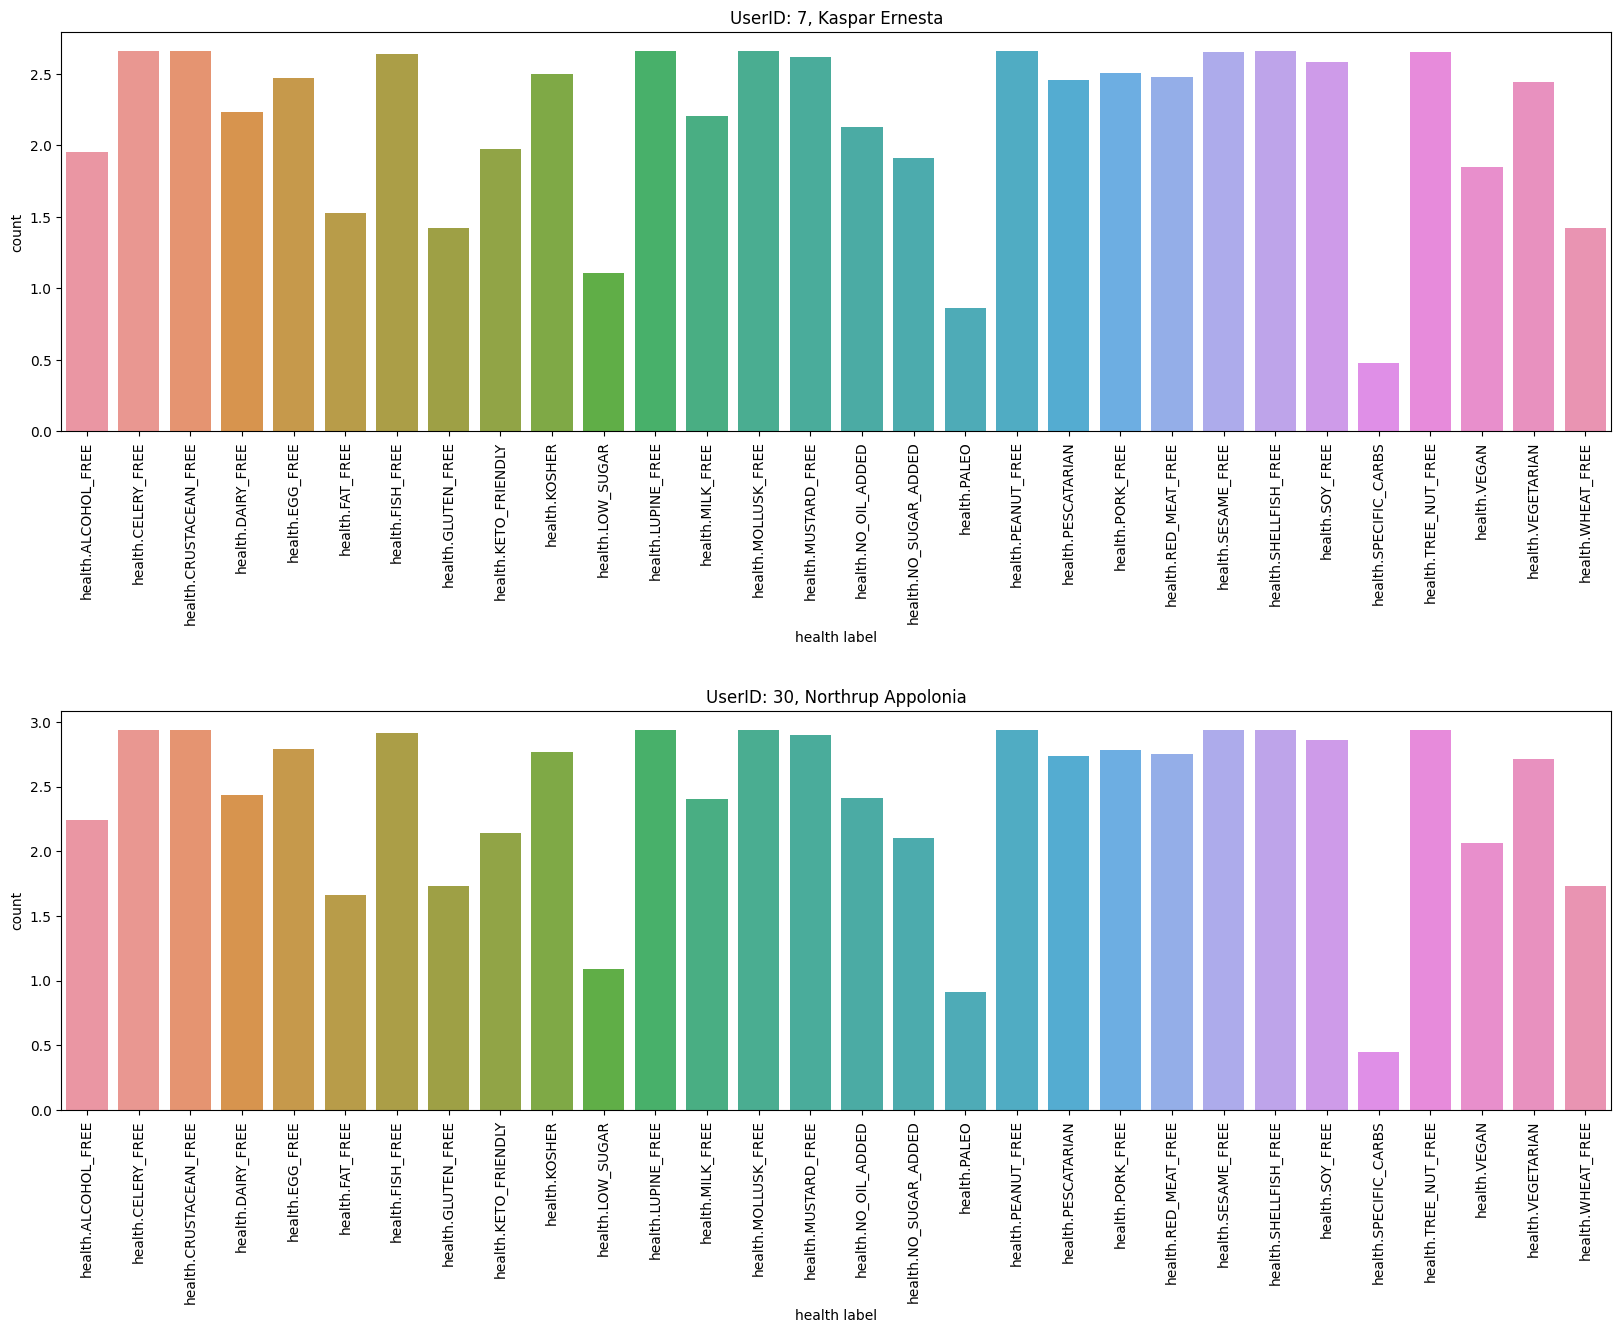

In [21]:
num_users = 2

fig = plt.figure(figsize=(20, (2 * num_users) + 10))
plt.subplots_adjust(hspace=0.7)

samples = random.choices(list(users[[c for c in users.columns.to_list() if "health" in c]].iterrows()), k=num_users)

for idx, (i, row) in enumerate(samples):
    plt.subplot(num_users, 1, idx+1)
    sns.barplot(data=pd.DataFrame({"health label": row.index, "count": row.values}), x='health label', y='count')
    _ = plt.xticks(rotation=90)
    plt.title(f"UserID: {users.loc[i]['user_id']}, {users.loc[i]['name']}")
    
plt.show()

## User Cuisine Preferences

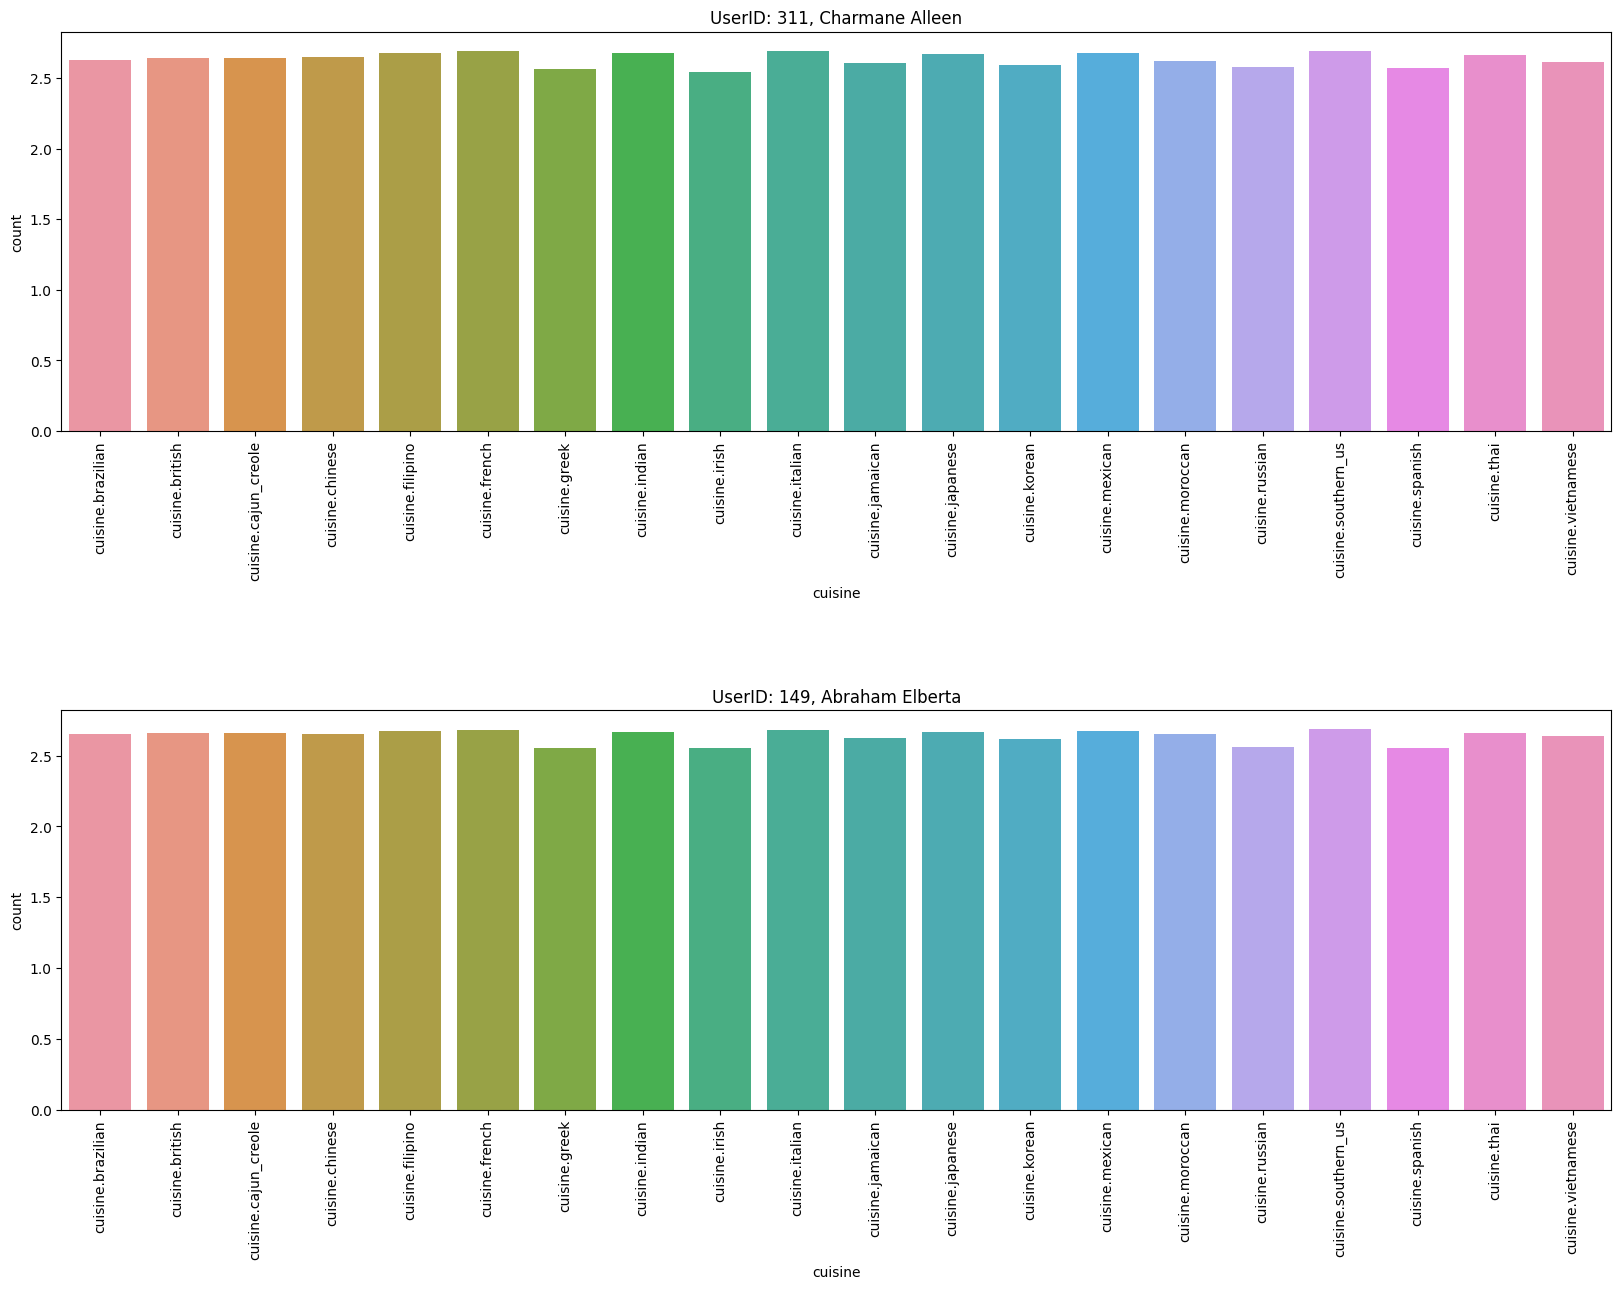

In [22]:
num_users = 2

fig = plt.figure(figsize=(20, (2 * num_users) + 10))
plt.subplots_adjust(hspace=0.7)

samples = random.choices(list(users[[c for c in users.columns.to_list() if "cuisine" in c]].iterrows()), k=num_users)

for idx, (i, row) in enumerate(samples):
    plt.subplot(num_users, 1, idx+1)
    sns.barplot(data=pd.DataFrame({"cuisine": row.index, "count": row.values}), x='cuisine', y='count')
    _ = plt.xticks(rotation=90)
    plt.title(f"UserID: {users.loc[i]['user_id']}, {users.loc[i]['name']}")
    
plt.show()